In [216]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import collections
from wordcloud import STOPWORDS
from scipy.sparse import csr_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [218]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.tsv", sep='\t')
train_data

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,1436222,Tarte rainforest after dark colored clay,1,Beauty/Makeup/Makeup Palettes,Tarte,36.0,1,"A brand-new, unused, unopened, undamaged item...."
1,402989,Mac mineralize skin finish,3,Beauty/Makeup/Face,MAC,15.0,1,"Color is gold deposit, about 85% of product left"
2,638275,White Case iPhone 6/6s,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,3.0,1,New Ultra thin Candy TPU Silicone Rubber Soft
3,1113629,Victoria's Secret push-up plunge,3,Women/Underwear/Bras,Victoria's Secret,18.0,1,VS sexy little thing multi way bras both size ...
4,328823,Disney Princess Toddler Boots Size 10,2,Kids/Girls 2T-5T/Shoes,Disney,13.0,1,New with out box!
...,...,...,...,...,...,...,...,...
1037769,674578,Nike Dri fit hooded top,2,Women/Athletic Apparel/Shirts & Tops,Nike,20.0,1,Like new. Sz L. Thumb holes
1037770,276890,Talk Red Hunter Boots,3,Women/Shoes/Boots,Hunter Boots,66.0,0,❤️❤️Sadly reselling because they are a little ...
1037771,1069670,NWT FREE SHIP CC 2Beanie Hat Beige+Taup,1,Men/Men's Accessories/Hats,NaN,20.0,1,NWT Unisex Ribbed cable knit beanie slouchy th...
1037772,35382,Winston cup snapback,3,Men/Men's Accessories/Hats,NaN,8.0,0,In great condition


In [219]:
train_data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          4382
brand_name           442947
price                     0
shipping                  0
item_description          2
dtype: int64

In [220]:
train_data['brand_name'].fillna(value="Not known", inplace=True)
train_data['item_description'].fillna(value="No description", inplace=True)
train_data.isnull().sum()

train_id                0
name                    0
item_condition_id       0
category_name        4382
brand_name              0
price                   0
shipping                0
item_description        0
dtype: int64

In [221]:
# differentiate into futher subcategories and adding columns
def category_split(row):
    try:
        text = row
        text1, text2, text3 = text.split('/')
        return text1, text2, text3
    except:
        return ("NoLabel", "NoLabel", "NoLabel")

In [222]:
train_data["subcat_1"], train_data["subcat_2"], train_data["subcat_3"] = zip(*train_data["category_name"].apply(lambda x: category_split(x)))
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,subcat_1,subcat_2,subcat_3
0,1436222,Tarte rainforest after dark colored clay,1,Beauty/Makeup/Makeup Palettes,Tarte,36.0,1,"A brand-new, unused, unopened, undamaged item....",Beauty,Makeup,Makeup Palettes
1,402989,Mac mineralize skin finish,3,Beauty/Makeup/Face,MAC,15.0,1,"Color is gold deposit, about 85% of product left",Beauty,Makeup,Face
2,638275,White Case iPhone 6/6s,1,"Electronics/Cell Phones & Accessories/Cases, C...",Not known,3.0,1,New Ultra thin Candy TPU Silicone Rubber Soft,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins"
3,1113629,Victoria's Secret push-up plunge,3,Women/Underwear/Bras,Victoria's Secret,18.0,1,VS sexy little thing multi way bras both size ...,Women,Underwear,Bras
4,328823,Disney Princess Toddler Boots Size 10,2,Kids/Girls 2T-5T/Shoes,Disney,13.0,1,New with out box!,Kids,Girls 2T-5T,Shoes


Number of unique categories: 11


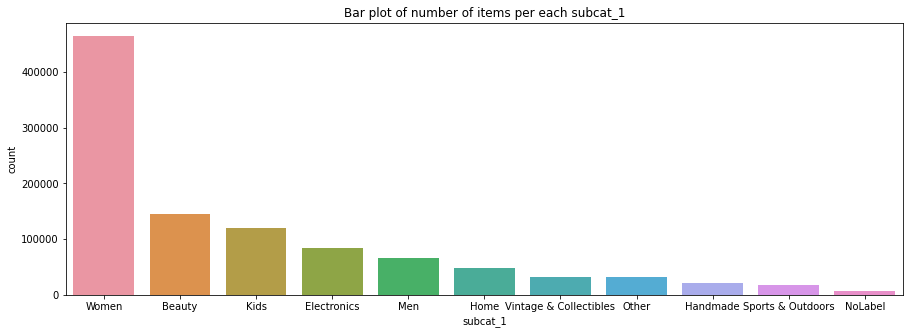

In [223]:
count = train_data['subcat_1'].value_counts()
print("Number of unique categories: {}".format(len(count)))
plt.figure(figsize=(15, 5))
sns.barplot(count.index, count)
plt.title("Bar plot of number of items per each subcat_1")
plt.xlabel('subcat_1')
plt.ylabel('count')
plt.show()

Number of unique categories: 10


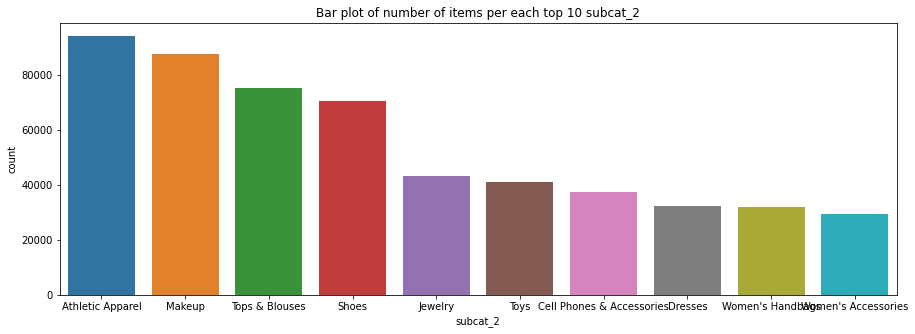

In [224]:
count = train_data['subcat_2'].value_counts()[:10]
print("Number of unique categories: {}".format(len(count)))
plt.figure(figsize=(15, 5))
sns.barplot(count.index, count)
plt.title("Bar plot of number of items per each top 10 subcat_2")
plt.xlabel('subcat_2')
plt.ylabel('count')
plt.show()

Number of unique categories: 10


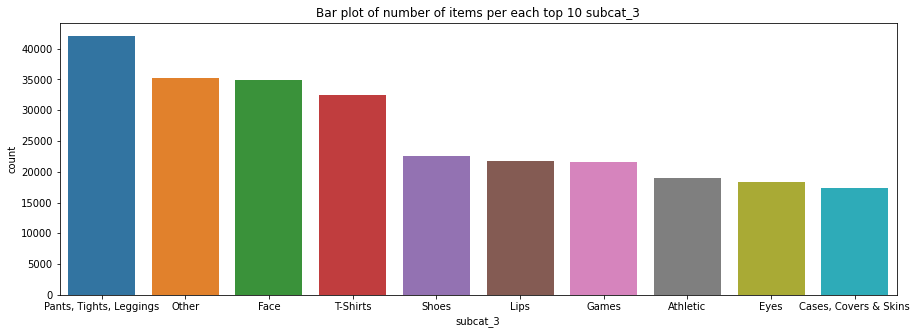

In [225]:
count = train_data['subcat_3'].value_counts()[:10]
print("Number of unique categories: {}".format(len(count)))
plt.figure(figsize=(15, 5))
sns.barplot(count.index, count)
plt.title("Bar plot of number of items per each top 10 subcat_3")
plt.xlabel('subcat_3')
plt.ylabel('count')
plt.show()

Number of unique categories: 10


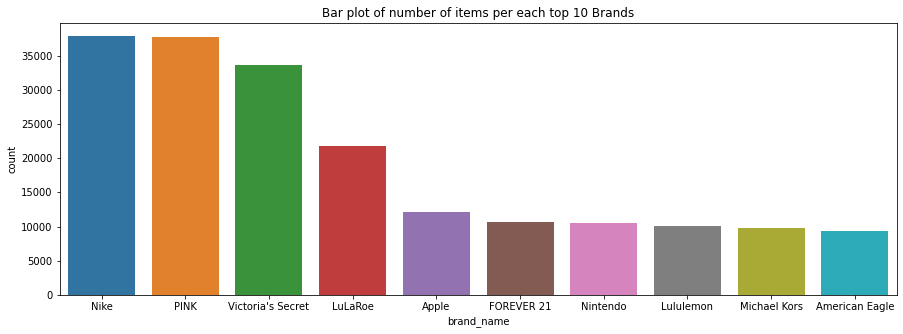

In [226]:
count = train_data['brand_name'].value_counts()[1:11]
print("Number of unique categories: {}".format(len(count)))
plt.figure(figsize=(15, 5))
sns.barplot(count.index, count)
plt.title("Bar plot of number of items per each top 10 Brands")
plt.xlabel('brand_name')
plt.ylabel('count')
plt.show()

Number of unique categories: 10


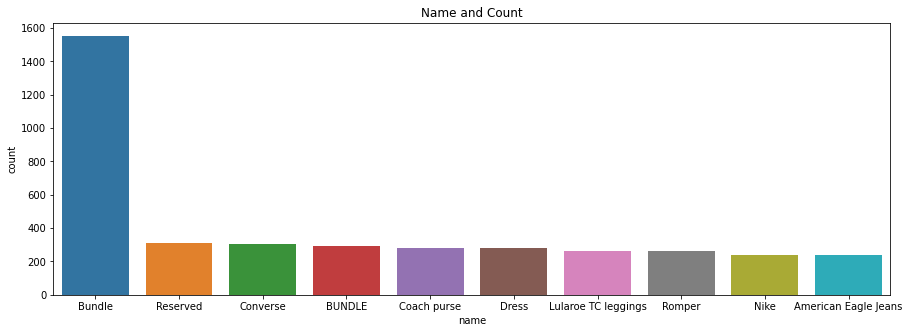

In [227]:
count = train_data['name'].value_counts()[:10]
print("Number of unique categories: {}".format(len(count)))
plt.figure(figsize=(15, 5))
sns.barplot(count.index, count)
plt.title("Name and Count")
plt.xlabel('name')
plt.ylabel('count')
plt.show()

Number of unique categories: 5


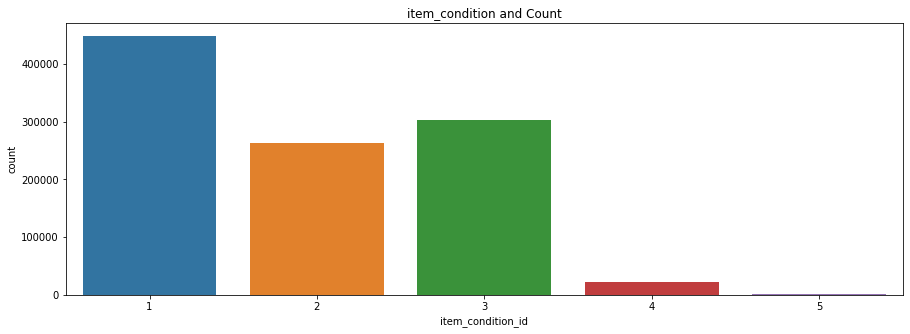

In [228]:
count = train_data['item_condition_id'].value_counts()
print("Number of unique categories: {}".format(len(count)))
plt.figure(figsize=(15, 5))
sns.barplot(count.index, count)
plt.title("item_condition and Count")
plt.xlabel('item_condition_id')
plt.ylabel('count')
plt.show()

In [229]:
train_data = train_data[train_data['price'] > 0].reset_index(drop=True)
train_data,cv_data=train_test_split(train_data,test_size=0.1,random_state=42)
print(train_data.shape)
print(cv_data.shape)

(933453, 11)
(103717, 11)


In [230]:
cv_data["subcat_1"], cv_data["subcat_2"], cv_data["subcat_3"] = zip(*cv_data["category_name"].apply(lambda x: category_split(x)))
cv_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,subcat_1,subcat_2,subcat_3
139488,1265533,Nike air Jordan 12 retro size 8,3,Men/Shoes/Athletic,Nike,96.0,0,Show regular signs of wear and comes with box,Men,Shoes,Athletic
792739,851595,Silktop scalp full lace wig human hair,2,Women/Women's Accessories/Hair Accessories,Not known,133.0,1,Please read No lower offers I ship fast Yes st...,Women,Women's Accessories,Hair Accessories
959523,782561,BBW 3 Wick Spooky Vanilla Candle,1,Beauty/Fragrance/Candles & Home Scents,Bath & Body Works,21.0,0,Brand New Spooky Vanilla 3 Wick 14.5oz Bath & ...,Beauty,Fragrance,Candles & Home Scents
944975,349188,New plus size leggings 1x 2x 3x,1,"Women/Athletic Apparel/Pants, Tights, Leggings",Not known,25.0,1,New Plus size white leggings 1x 2x 3c FREE US ...,Women,Athletic Apparel,"Pants, Tights, Leggings"
371823,793599,Sparkly Jelly Sandal Flats,4,Women/Shoes/Flats,Not known,14.0,1,I love these so much and have them in a ton of...,Women,Shoes,Flats


In [231]:
cv_data['item_description'].fillna(value='No description given',inplace=True)
cv_data['brand_name'].fillna(value='Not known',inplace=True)
cv_data.isnull().sum()

train_id               0
name                   0
item_condition_id      0
category_name        402
brand_name             0
price                  0
shipping               0
item_description       0
subcat_1               0
subcat_2               0
subcat_3               0
dtype: int64

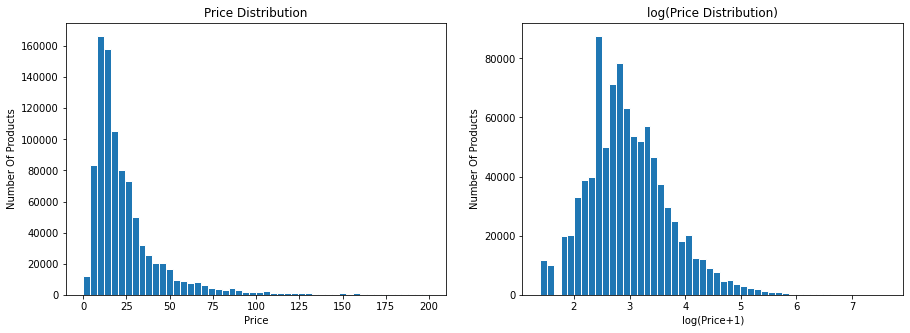

In [232]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(train_data['price'],bins=50,range=[0,200],edgecolor='white')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel("Number Of Products")
plt.subplot(1,2,2)
log_price=[np.log(i+1) for i in train_data['price']]
plt.hist(np.log(train_data['price']+1),bins=50,edgecolor='white')
plt.title("log(Price Distribution)")
plt.xlabel("log(Price+1)")
plt.ylabel("Number Of Products")
plt.show()

In [233]:
train_data['target']=np.log(np.array(train_data['price'].values)+1)
cv_data['target']=np.log(np.array(cv_data['price'].values)+1)

In [234]:
test_data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.tsv", sep='\t')
test_data.head(3)

,id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,1048243,Herschel Retreat Backpack,2,"Men/Men's Accessories/Backpacks, Bags & Briefc...",Urban Outfitters,0,In great condition! Only issue is magnet that ...
1,86986,2 pairs of Lebron,3,Men/Shoes/Athletic,Nike,1,Lebron soldier 10 size 10.5 9/10 condition Leb...
2,698316,Mario Kart Double Dash with bonus disc,3,Vintage & Collectibles/Electronics/Video Game,Nintendo,1,Good shape work no problem


In [235]:
print("shape of the test data: ",test_data.shape)
test_data.isnull().sum()

shape of the test data:  (444761, 7)


id                        0
name                      0
item_condition_id         0
category_name          1945
brand_name           189735
shipping                  0
item_description          2
dtype: int64

In [236]:
test_data['item_description'].fillna(value='No description given',inplace=True)
test_data['brand_name'].fillna(value='Not known',inplace=True)
test_data.isnull().sum()

id                      0
name                    0
item_condition_id       0
category_name        1945
brand_name              0
shipping                0
item_description        0
dtype: int64

In [237]:
test_data["subcat_1"], test_data["subcat_2"], test_data["subcat_3"] = zip(*test_data["category_name"].apply(lambda x: category_split(x)))
test_data.head()

,id,name,item_condition_id,category_name,brand_name,shipping,item_description,subcat_1,subcat_2,subcat_3
0,1048243,Herschel Retreat Backpack,2,"Men/Men's Accessories/Backpacks, Bags & Briefc...",Urban Outfitters,0,In great condition! Only issue is magnet that ...,Men,Men's Accessories,"Backpacks, Bags & Briefcases"
1,86986,2 pairs of Lebron,3,Men/Shoes/Athletic,Nike,1,Lebron soldier 10 size 10.5 9/10 condition Leb...,Men,Shoes,Athletic
2,698316,Mario Kart Double Dash with bonus disc,3,Vintage & Collectibles/Electronics/Video Game,Nintendo,1,Good shape work no problem,Vintage & Collectibles,Electronics,Video Game
3,268868,Tokidoki unicorno kaiju and strawberry,2,Vintage & Collectibles/Collectibles/Figurine,tokidoki,1,Both new with foil and box.,Vintage & Collectibles,Collectibles,Figurine
4,1360398,"Like Ugg Cardy, grey knit top boot",2,Women/Shoes/Boots,Not known,0,"Brand new, not even a foot near them! Size 8 b...",Women,Shoes,Boots


In [238]:
stopwords=set(stopwords.words('english'))

In [239]:
def stopwords_count(data):
    """this function counts the number of stopwords in each of the item_description"""
    count_stopwords=[]
    for i in tqdm(data['item_description']):
        count=0
        for j in i.split(' '):
            if j in stopwords: count+=1  #finding if the word is present in the nltk stopwords or not
        count_stopwords.append(count)
    return count_stopwords

In [240]:
train_data['count_stopwords']=stopwords_count(train_data)
cv_data['count_stopwords']=stopwords_count(cv_data)
test_data['count_stopwords']=stopwords_count(test_data)


100%|██████████| 933453/933453 [00:03<00:00, 239223.33it/s]

100%|██████████| 103717/103717 [00:00<00:00, 225099.55it/s]

100%|██████████| 444761/444761 [00:01<00:00, 249319.07it/s]


In [241]:
train_data['count_stopwords'].describe()

count    933453.000000
mean          5.983621
std           9.063161
min           0.000000
25%           0.000000
50%           3.000000
75%           8.000000
max         118.000000
Name: count_stopwords, dtype: float64

In [242]:
def decontracted(phrase):
    """this function removies shorthands for the textual data..."""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [243]:
def text_preprocessing(data):
    """this function performs preprocessing the item_description """
    preprocessed_total = []
    for sentance in tqdm(data['item_description'].values):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)  #removing stop words
        preprocessed_total.append(sent.lower().strip())
    return preprocessed_total

In [244]:
train_data['item_description']=text_preprocessing(train_data)
cv_data['item_description']=text_preprocessing(cv_data)
test_data['item_description']=text_preprocessing(test_data)


100%|██████████| 933453/933453 [00:23<00:00, 39729.96it/s]

100%|██████████| 103717/103717 [00:02<00:00, 38263.89it/s]

100%|██████████| 444761/444761 [00:11<00:00, 39593.29it/s]


In [245]:
def description_length(data):
    """this function finds the length of the description basing on spaces in the statement"""
    description_length=[]
    for i in data['item_description']:
        description_length.append(len(i.split(' '))) #splitting statement using spaces and finding length of it
    return description_length

In [246]:
print("processing item_description in train_data...")
train_data['description_length']=description_length(train_data)
cv_data['description_length']=description_length(cv_data)
print(train_data.iloc[100]['item_description'],train_data.iloc[100]['description_length'])
print("="*100)
print("processing item_description in test_data...")
test_data['description_length']=description_length(test_data)
print(test_data.iloc[100]['item_description'],test_data.iloc[100]['description_length'])

processing item_description in train_data...
brand new 1 victoria secret tote bag limited edition tote 19 5 l x 7 w x 16 h 100 mesh items guaranteed brand new 100 authentic sales final returns exchanges please measure size colors order carefully sure get products work want issues purchase price firm discount items please ask discount combine shipping bundles shipping cost 1 oz 8 oz rm 8 oz 3 lbs rm 3 lbs 10 lbs rm 10 lbs 20 lbs rm 76
processing item_description in test_data...
custom listing contains twilight solid perfume love apple bubble bar x4 bunny bubble bar x3 15


In [247]:
train_data['description_length'].describe()

count    933453.000000
mean         18.041188
std          20.640420
min           1.000000
25%           6.000000
50%          11.000000
75%          21.000000
max         251.000000
Name: description_length, dtype: float64

In [248]:
"""train_data['name_len'] = train_data['name'].apply(lambda x: len(x))
train_data['des_len'] = train_data['item_description'].apply(lambda x: len(x))
train_data['desc_word_count'] = train_data['item_description'].apply(lambda x: len(x.split()))
train_data['name_word_count'] = train_data['name'].apply(lambda x: len(x.split()))
train_data['desc_letters_per_word'] = train_data['des_len'] / train_data['desc_word_count']
train_data['name_letters_per_word'] = train_data['name_len'] / train_data['name_word_count']
train_data['price_in_description'] = train_data['item_description'].str.contains('[rm]', regex=False).astype('category')
train_data['price_in_name'] = train_data['name'].str.contains('[rm]', regex=False).astype('category')"""

"train_data['name_len'] = train_data['name'].apply(lambda x: len(x))\ntrain_data['des_len'] = train_data['item_description'].apply(lambda x: len(x))\ntrain_data['desc_word_count'] = train_data['item_description'].apply(lambda x: len(x.split()))\ntrain_data['name_word_count'] = train_data['name'].apply(lambda x: len(x.split()))\ntrain_data['desc_letters_per_word'] = train_data['des_len'] / train_data['desc_word_count']\ntrain_data['name_letters_per_word'] = train_data['name_len'] / train_data['name_word_count']\ntrain_data['price_in_description'] = train_data['item_description'].str.contains('[rm]', regex=False).astype('category')\ntrain_data['price_in_name'] = train_data['name'].str.contains('[rm]', regex=False).astype('category')"

In [249]:
train_data.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'subcat_1', 'subcat_2',
       'subcat_3', 'target', 'count_stopwords', 'description_length'],
      dtype='object')

In [250]:
"""test_data['name_len'] = test_data['name'].apply(lambda x: len(x))
test_data['des_len'] = test_data['item_description'].apply(lambda x: len(x))
test_data['desc_word_count'] = test_data['item_description'].apply(lambda x: len(x.split()))
test_data['name_word_count'] = test_data['name'].apply(lambda x: len(x.split()))
test_data['desc_letters_per_word'] = test_data['des_len'] / test_data['desc_word_count']
test_data['name_letters_per_word'] = test_data['name_len'] / test_data['name_word_count']
test_data['price_in_description'] = test_data['item_description'].str.contains('[rm]', regex=False).astype('category')
test_data['price_in_name'] = test_data['name'].str.contains('[rm]', regex=False).astype('category')"""

"test_data['name_len'] = test_data['name'].apply(lambda x: len(x))\ntest_data['des_len'] = test_data['item_description'].apply(lambda x: len(x))\ntest_data['desc_word_count'] = test_data['item_description'].apply(lambda x: len(x.split()))\ntest_data['name_word_count'] = test_data['name'].apply(lambda x: len(x.split()))\ntest_data['desc_letters_per_word'] = test_data['des_len'] / test_data['desc_word_count']\ntest_data['name_letters_per_word'] = test_data['name_len'] / test_data['name_word_count']\ntest_data['price_in_description'] = test_data['item_description'].str.contains('[rm]', regex=False).astype('category')\ntest_data['price_in_name'] = test_data['name'].str.contains('[rm]', regex=False).astype('category')"

In [251]:
"""cv_data['name_len'] = cv_data['name'].apply(lambda x: len(x))
cv_data['des_len'] = cv_data['item_description'].apply(lambda x: len(x))
cv_data['desc_word_count'] = cv_data['item_description'].apply(lambda x: len(x.split()))
cv_data['name_word_count'] = cv_data['name'].apply(lambda x: len(x.split()))
cv_data['desc_letters_per_word'] = cv_data['des_len'] / cv_data['desc_word_count']
cv_data['name_letters_per_word'] = cv_data['name_len'] / cv_data['name_word_count']
cv_data['price_in_description'] = cv_data['item_description'].str.contains('[rm]', regex=False).astype('category')
cv_data['price_in_name'] = cv_data['name'].str.contains('[rm]', regex=False).astype('category')"""

"cv_data['name_len'] = cv_data['name'].apply(lambda x: len(x))\ncv_data['des_len'] = cv_data['item_description'].apply(lambda x: len(x))\ncv_data['desc_word_count'] = cv_data['item_description'].apply(lambda x: len(x.split()))\ncv_data['name_word_count'] = cv_data['name'].apply(lambda x: len(x.split()))\ncv_data['desc_letters_per_word'] = cv_data['des_len'] / cv_data['desc_word_count']\ncv_data['name_letters_per_word'] = cv_data['name_len'] / cv_data['name_word_count']\ncv_data['price_in_description'] = cv_data['item_description'].str.contains('[rm]', regex=False).astype('category')\ncv_data['price_in_name'] = cv_data['name'].str.contains('[rm]', regex=False).astype('category')"

In [252]:
def branded(data):
    """this function assigns a value 1 if a product has brand_name else 0"""
    is_branded=[]
    for i in data['brand_name']:
        if i=='Not known': is_branded.append(0) #if it is a Nan value i.e.. unknown brand make it as 0.
        else: is_branded.append(1)
    return is_branded
train_data['is_branded']=branded(train_data)
cv_data['is_branded']=branded(cv_data)
test_data['is_branded']=branded(test_data)

In [253]:
def transform_test(base_col, feat_col):
    '''
    Returns feat_col column of test data by mapping from the values already calculated for the same column in train data
    
    Parameters:
    
    base_col: column based on which a transform(count, mean, median) has been applied
    
    feat_col: desired feature column after applying the transform
    '''
    #Create dictionary of feature values from train data
    di = pd.Series(train_data[feat_col].values, index = train_data[base_col].values).to_dict()
    
    #Map test data using dictionary and fill NAs with 0
    
    if base_col == 'item_condition_id':
        #No chance of NAs
        return test_data[base_col].map(di).astype(float)
        
    return test_data[base_col].map(di).fillna(0)

In [254]:
def transform_test1(base_col, feat_col):
    '''
    Returns feat_col column of test data by mapping from the values already calculated for the same column in train data
    
    Parameters:
    
    base_col: column based on which a transform(count, mean, median) has been applied
    
    feat_col: desired feature column after applying the transform
    '''
    #Create dictionary of feature values from train data
    di = pd.Series(cv_data[feat_col].values, index = cv_data[base_col].values).to_dict()
    
    #Map test data using dictionary and fill NAs with 0
    
    if base_col == 'item_condition_id':
        #No chance of NAs
        return test_data[base_col].map(di).astype(float)
        
    return test_data[base_col].map(di).fillna(0)

In [255]:
"""train_data['brand_mean_price'] = train_data.groupby('brand_name')['price'].transform('mean')
cv_data['brand_mean_price'] = cv_data.groupby('brand_name')['price'].transform('mean')
test_data['brand_mean_price'] = transform_test('brand_name', 'brand_mean_price')

train_data['subcat_1_mean_price'] = train_data.groupby('subcat_1')['price'].transform('mean')
cv_data['subcat_1_mean_price'] = cv_data.groupby('subcat_1')['price'].transform('mean')
test_data['subcat_1_mean_price'] = transform_test('subcat_1', 'subcat_1_mean_price')

train_data['subcat_2_mean_price'] = train_data.groupby('subcat_2')['price'].transform('mean')
cv_data['subcat_2_mean_price'] = cv_data.groupby('subcat_2')['price'].transform('mean')
test_data['subcat_2_mean_price'] = transform_test('subcat_2', 'subcat_2_mean_price')

train_data['subcat_3_mean_price'] = train_data.groupby('subcat_3')['price'].transform('mean')
cv_data['subcat_3_mean_price'] = cv_data.groupby('subcat_3')['price'].transform('mean')
test_data['subcat_3_mean_price'] = transform_test('subcat_3', 'subcat_3_mean_price')

train_data['condition_mean_price'] = train_data.groupby('item_condition_id')['price'].transform('mean')
cv_data['condition_mean_price'] = cv_data.groupby('item_condition_id')['price'].transform('mean')
test_data['condition_mean_price'] = transform_test('item_condition_id', 'condition_mean_price')"""

"train_data['brand_mean_price'] = train_data.groupby('brand_name')['price'].transform('mean')\ncv_data['brand_mean_price'] = cv_data.groupby('brand_name')['price'].transform('mean')\ntest_data['brand_mean_price'] = transform_test('brand_name', 'brand_mean_price')\n\ntrain_data['subcat_1_mean_price'] = train_data.groupby('subcat_1')['price'].transform('mean')\ncv_data['subcat_1_mean_price'] = cv_data.groupby('subcat_1')['price'].transform('mean')\ntest_data['subcat_1_mean_price'] = transform_test('subcat_1', 'subcat_1_mean_price')\n\ntrain_data['subcat_2_mean_price'] = train_data.groupby('subcat_2')['price'].transform('mean')\ncv_data['subcat_2_mean_price'] = cv_data.groupby('subcat_2')['price'].transform('mean')\ntest_data['subcat_2_mean_price'] = transform_test('subcat_2', 'subcat_2_mean_price')\n\ntrain_data['subcat_3_mean_price'] = train_data.groupby('subcat_3')['price'].transform('mean')\ncv_data['subcat_3_mean_price'] = cv_data.groupby('subcat_3')['price'].transform('mean')\ntest_

In [256]:
"""train_data['brand_median_price'] = train_data.groupby('brand_name')['price'].transform('median')
cv_data['brand_median_price'] = cv_data.groupby('brand_name')['price'].transform('median')
test_data['brand_median_price'] = transform_test('brand_name', 'brand_median_price')

train_data['subcat_1_median_price'] = train_data.groupby('subcat_1')['price'].transform('median')
cv_data['subcat_1_median_price'] = cv_data.groupby('subcat_1')['price'].transform('median')
test_data['subcat_1_median_price'] = transform_test('subcat_1', 'subcat_1_median_price')

train_data['subcat_2_median_price'] = train_data.groupby('subcat_2')['price'].transform('median')
cv_data['subcat_2_median_price'] = cv_data.groupby('subcat_2')['price'].transform('median')
test_data['subcat_2_median_price'] = transform_test('subcat_2', 'subcat_2_median_price')

train_data['subcat_3_median_price'] = train_data.groupby('subcat_3')['price'].transform('median')
cv_data['subcat_3_median_price'] = cv_data.groupby('subcat_3')['price'].transform('median')
test_data['subcat_3_median_price'] = transform_test('subcat_3', 'subcat_3_median_price')

train_data['condition_median_price'] = train_data.groupby('item_condition_id')['price'].transform('median')
cv_data['condition_median_price'] = cv_data.groupby('item_condition_id')['price'].transform('median')
test_data['condition_median_price'] = transform_test('item_condition_id', 'condition_median_price')"""

"train_data['brand_median_price'] = train_data.groupby('brand_name')['price'].transform('median')\ncv_data['brand_median_price'] = cv_data.groupby('brand_name')['price'].transform('median')\ntest_data['brand_median_price'] = transform_test('brand_name', 'brand_median_price')\n\ntrain_data['subcat_1_median_price'] = train_data.groupby('subcat_1')['price'].transform('median')\ncv_data['subcat_1_median_price'] = cv_data.groupby('subcat_1')['price'].transform('median')\ntest_data['subcat_1_median_price'] = transform_test('subcat_1', 'subcat_1_median_price')\n\ntrain_data['subcat_2_median_price'] = train_data.groupby('subcat_2')['price'].transform('median')\ncv_data['subcat_2_median_price'] = cv_data.groupby('subcat_2')['price'].transform('median')\ntest_data['subcat_2_median_price'] = transform_test('subcat_2', 'subcat_2_median_price')\n\ntrain_data['subcat_3_median_price'] = train_data.groupby('subcat_3')['price'].transform('median')\ncv_data['subcat_3_median_price'] = cv_data.groupby('su

In [257]:
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer=CountVectorizer().fit(train_data['subcat_1'])                     #fitting
bow_cat1_train=countvectorizer.transform(train_data['subcat_1'])
bow_cat1_cv=countvectorizer.transform(cv_data['subcat_1'])
bow_cat1_test=countvectorizer.transform(test_data['subcat_1'])
print("After Vectorization of sub category1 feature: ")
print(bow_cat1_train.shape)
print(bow_cat1_cv.shape)
print(bow_cat1_test.shape)
print("Some Features are: ")
print(countvectorizer.get_feature_names())
print("="*125)
countvectorizer=CountVectorizer().fit(train_data['subcat_2'])   #fitting
bow_cat2_train=countvectorizer.transform(train_data['subcat_2'])
bow_cat2_cv=countvectorizer.transform(cv_data['subcat_2'])
bow_cat2_test=countvectorizer.transform(test_data['subcat_2'])
print("After Vectorization of sub category2 feature: ")
print(bow_cat2_train.shape)
print(bow_cat2_cv.shape)
print(bow_cat2_test.shape)
print("Some Features are: ")
print(countvectorizer.get_feature_names()[50:75])
print("="*125)
countvectorizer=CountVectorizer().fit(train_data['subcat_3'])   #fitting
bow_cat3_train=countvectorizer.transform(train_data['subcat_3'])
bow_cat3_cv=countvectorizer.transform(cv_data['subcat_3'])
bow_cat3_test=countvectorizer.transform(test_data['subcat_3'])
print("After Vectorization of sub category3 feature: ")
print(bow_cat3_train.shape)
print(bow_cat3_cv.shape)
print(bow_cat3_test.shape)
print("Some Features are: ")
print(countvectorizer.get_feature_names()[50:75])
print("="*125)
countvectorizer=CountVectorizer().fit(train_data['brand_name'])  #fitting
bow_brand_train=countvectorizer.transform(train_data['brand_name'])
bow_brand_cv=countvectorizer.transform(cv_data['brand_name'])
bow_brand_test=countvectorizer.transform(test_data['brand_name'])
print("After Vectorization of brand_name feature: ")
print(bow_brand_train.shape)
print(bow_brand_cv.shape)
print(bow_brand_test.shape)
print("Some Features are: ")
print(countvectorizer.get_feature_names()[50:75])
print("="*125)

After Vectorization of sub category1 feature: 
(933453, 13)
(103717, 13)
(444761, 13)
Some Features are: 
['beauty', 'collectibles', 'electronics', 'handmade', 'home', 'kids', 'men', 'nolabel', 'other', 'outdoors', 'sports', 'vintage', 'women']
After Vectorization of sub category2 feature: 
(933453, 142)
(103717, 142)
(444761, 142)
Some Features are: 
['feeding', 'footwear', 'fragrance', 'furniture', 'games', 'gear', 'geekery', 'girls', 'glass', 'golf', 'goods', 'gps', 'hair', 'handbags', 'health', 'holidays', 'home', 'hoodies', 'housewares', 'instruments', 'items', 'jackets', 'jeans', 'jewelry', 'kids']
After Vectorization of sub category3 feature: 
(933453, 941)
(103717, 941)
(444761, 941)
Some Features are: 
['baskets', 'bass', 'bath', 'bathing', 'bathroom', 'batteries', 'beach', 'bead', 'beads', 'bear', 'bears', 'bed', 'bedding', 'bedroom', 'beds', 'bedspreads', 'beer', 'belt', 'belts', 'beverage', 'bibles', 'bibs', 'bike', 'binoculars', 'bins']
After Vectorization of brand_name fe

In [258]:
countvectorizer=CountVectorizer(min_df=10).fit(train_data['name'])  #fitting
bow_name_train=countvectorizer.transform(train_data['name'])
bow_name_cv=countvectorizer.transform(cv_data['name'])
bow_name_test=countvectorizer.transform(test_data['name'])
print("After Vectorization of brand_name feature: ")
print(bow_name_train.shape)
print(bow_name_cv.shape)
print(bow_name_test.shape)
print("Some Features are: ")
print(countvectorizer.get_feature_names()[10000:10025])

After Vectorization of brand_name feature: 
(933453, 14158)
(103717, 14158)
(444761, 14158)
Some Features are: 
['premiere', 'premium', 'prenatal', 'preowned', 'prep', 'prepaid', 'preppy', 'preschool', 'prescott', 'prescription', 'present', 'presents', 'president', 'presidio', 'presley', 'press', 'pressed', 'pressure', 'prestige', 'presto', 'preston', 'prestos', 'pretend', 'pretty', 'pretzel']


In [259]:
tfidfvectorizer=TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=5000).fit(train_data['item_description']) #fitting
tfidf_description_train=tfidfvectorizer.transform(train_data['item_description'])
tfidf_description_cv=tfidfvectorizer.transform(cv_data['item_description'])
tfidf_description_test=tfidfvectorizer.transform(test_data['item_description'])
print("After Vectorization of item description feature: ")
print(tfidf_description_train.shape)
print(tfidf_description_cv.shape)
print(tfidf_description_test.shape)
print("Some Features are: ")
print(tfidfvectorizer.get_feature_names()[3025:3050])

After Vectorization of item description feature: 
(933453, 5000)
(103717, 5000)
(444761, 5000)
Some Features are: 
['packets', 'packing', 'packs', 'pacsun', 'pad', 'padded', 'padding', 'pads', 'page', 'pages', 'paid', 'paid product', 'paid rm', 'pain', 'paint', 'painted', 'pair', 'pair rm', 'paired', 'pairs', 'pairs rm', 'paisley', 'pajama', 'pajamas', 'pale']


In [260]:
scaler = StandardScaler().fit(np.array(train_data['description_length']).reshape(-1,1))  #fitting
length_train=scaler.transform(np.array(train_data['description_length']).reshape(-1,1))
length_cv=scaler.transform(np.array(cv_data['description_length']).reshape(-1,1))
length_test=scaler.transform(np.array(test_data['description_length']).reshape(-1,1))
print(length_train[1:5].reshape(1,-1)[0])       #printing 5 random description lengths
print("After Preprocessing of description length:")
print(length_train.shape)
print(length_cv.shape)
print(length_test.shape)
print("="*125)
"""
scaler = StandardScaler().fit(np.array(train_data['name_len']).reshape(-1,1))  #fitting
lengthName_train=scaler.transform(np.array(train_data['name_len']).reshape(-1,1))
lengthName_cv=scaler.transform(np.array(cv_data['name_len']).reshape(-1,1))
lengthName_test=scaler.transform(np.array(test_data['name_len']).reshape(-1,1))
print(lengthName_train[1:5].reshape(1,-1)[0])       #printing 5 random description lengths
print("After Preprocessing of description length:")
print(lengthName_train.shape)
print(lengthName_cv.shape)
print(lengthName_test.shape)
print("="*125)

scaler = StandardScaler().fit(np.array(train_data['des_len']).reshape(-1,1))  #fitting
lengthDes_train=scaler.transform(np.array(train_data['des_len']).reshape(-1,1))
lengthDes_cv=scaler.transform(np.array(cv_data['des_len']).reshape(-1,1))
lengthDes_test=scaler.transform(np.array(test_data['des_len']).reshape(-1,1))
print(lengthDes_train[1:5].reshape(1,-1)[0])       #printing 5 random description lengths
print("After Preprocessing of description length:")
print(lengthDes_train.shape)
print(lengthDes_cv.shape)
print(lengthDes_test.shape)
print("="*125)

scaler = StandardScaler().fit(np.array(train_data['desc_word_count']).reshape(-1,1))  #fitting
lengthDwc_train=scaler.transform(np.array(train_data['desc_word_count']).reshape(-1,1))
lengthDwc_cv=scaler.transform(np.array(cv_data['desc_word_count']).reshape(-1,1))
lengthDwc_test=scaler.transform(np.array(test_data['desc_word_count']).reshape(-1,1))
print(lengthDwc_train[1:5].reshape(1,-1)[0])       #printing 5 random description lengths
print("After Preprocessing of description length:")
print(lengthDwc_train.shape)
print(lengthDwc_cv.shape)
print(lengthDwc_test.shape)
print("="*125)

scaler = StandardScaler().fit(np.array(train_data['name_word_count']).reshape(-1,1))  #fitting
lengthNwc_train=scaler.transform(np.array(train_data['name_word_count']).reshape(-1,1))
lengthNwc_cv=scaler.transform(np.array(cv_data['name_word_count']).reshape(-1,1))
lengthNwc_test=scaler.transform(np.array(test_data['name_word_count']).reshape(-1,1))
print(lengthNwc_train[1:5].reshape(1,-1)[0])       #printing 5 random description lengths
print("After Preprocessing of description length:")
print(lengthNwc_train.shape)
print(lengthNwc_cv.shape)
print(lengthNwc_test.shape)
print("="*125)

scaler = StandardScaler().fit(np.array(train_data['name_letters_per_word']).reshape(-1,1))  #fitting
lengthNlpw_train=scaler.transform(np.array(train_data['name_letters_per_word']).reshape(-1,1))
lengthNlpw_cv=scaler.transform(np.array(cv_data['name_letters_per_word']).reshape(-1,1))
lengthNlpw_test=scaler.transform(np.array(test_data['name_letters_per_word']).reshape(-1,1))
print(lengthNlpw_train[1:5].reshape(1,-1)[0])       #printing 5 random description lengths
print("After Preprocessing of description length:")
print(lengthNlpw_train.shape)
print(lengthNlpw_cv.shape)
print(lengthNlpw_test.shape)
print("="*125)
"""
scaler = StandardScaler().fit(np.array(train_data['count_stopwords']).reshape(-1,1))   #fitting
stopword_train=scaler.transform(np.array(train_data['count_stopwords']).reshape(-1,1))
stopword_cv=scaler.transform(np.array(cv_data['count_stopwords']).reshape(-1,1))
stopword_test=scaler.transform(np.array(test_data['count_stopwords']).reshape(-1,1))
print(stopword_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(stopword_train.shape)
print(stopword_cv.shape)
print(stopword_test.shape)

[-0.48648202 -0.48648202 -0.38958471  1.01542619]
After Preprocessing of description length:
(933453, 1)
(103717, 1)
(444761, 1)
[-0.3292033   1.8775334   0.99483872  0.11214404 -0.66021381]
After Preprocessing of count_stopwords feature:
(933453, 1)
(103717, 1)
(444761, 1)


In [261]:
"""
brand_mean_price             0
subcat_1_mean_price          0
subcat_2_mean_price          0
subcat_3_mean_price          0
condition_mean_price         0
brand_median_price           0
subcat_1_median_price        0
subcat_2_median_price        0
subcat_3_median_price        0
condition_median_price 

scaler = StandardScaler().fit(np.array(train_data['brand_mean_price']).reshape(-1,1))   #fitting
bmp_train=scaler.transform(np.array(train_data['brand_mean_price']).reshape(-1,1))
bmp_cv=scaler.transform(np.array(cv_data['brand_mean_price']).reshape(-1,1))
bmp_test=scaler.transform(np.array(test_data['brand_mean_price']).reshape(-1,1))
print(bmp_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(bmp_train.shape)
print(bmp_cv.shape)
print(bmp_test.shape)

scaler = StandardScaler().fit(np.array(train_data['subcat_1_mean_price']).reshape(-1,1))   #fitting
submean1_train=scaler.transform(np.array(train_data['subcat_1_mean_price']).reshape(-1,1))
submean1_cv=scaler.transform(np.array(cv_data['subcat_1_mean_price']).reshape(-1,1))
submean1_test=scaler.transform(np.array(test_data['subcat_1_mean_price']).reshape(-1,1))
print(submean1_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(submean1_train.shape)
print(submean1_cv.shape)
print(submean1_test.shape)

scaler = StandardScaler().fit(np.array(train_data['subcat_2_mean_price']).reshape(-1,1))   #fitting
submean2_train=scaler.transform(np.array(train_data['subcat_2_mean_price']).reshape(-1,1))
submean2_cv=scaler.transform(np.array(cv_data['subcat_2_mean_price']).reshape(-1,1))
submean2_test=scaler.transform(np.array(test_data['subcat_2_mean_price']).reshape(-1,1))
print(submean2_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(submean2_train.shape)
print(submean2_cv.shape)
print(submean2_test.shape)

scaler = StandardScaler().fit(np.array(train_data['subcat_3_mean_price']).reshape(-1,1))   #fitting
submean3_train=scaler.transform(np.array(train_data['subcat_3_mean_price']).reshape(-1,1))
submean3_cv=scaler.transform(np.array(cv_data['subcat_3_mean_price']).reshape(-1,1))
submean3_test=scaler.transform(np.array(test_data['subcat_3_mean_price']).reshape(-1,1))
print(submean3_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(submean3_train.shape)
print(submean3_cv.shape)
print(submean3_test.shape)

scaler = StandardScaler().fit(np.array(train_data['condition_mean_price']).reshape(-1,1))   #fitting
cmp_train=scaler.transform(np.array(train_data['condition_mean_price']).reshape(-1,1))
cmp_cv=scaler.transform(np.array(cv_data['condition_mean_price']).reshape(-1,1))
cmp_test=scaler.transform(np.array(test_data['condition_mean_price']).reshape(-1,1))
print(cmp_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(cmp_train.shape)
print(cmp_cv.shape)
print(cmp_test.shape)

scaler = StandardScaler().fit(np.array(train_data['brand_median_price']).reshape(-1,1))   #fitting
bmedp_train=scaler.transform(np.array(train_data['brand_median_price']).reshape(-1,1))
bmedp_cv=scaler.transform(np.array(cv_data['brand_median_price']).reshape(-1,1))
bmedp_test=scaler.transform(np.array(test_data['brand_median_price']).reshape(-1,1))
print(bmedp_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(bmedp_train.shape)
print(bmedp_cv.shape)
print(bmedp_test.shape)

scaler = StandardScaler().fit(np.array(train_data['subcat_1_median_price']).reshape(-1,1))   #fitting
submedian1_train=scaler.transform(np.array(train_data['subcat_1_median_price']).reshape(-1,1))
submedian1_cv=scaler.transform(np.array(cv_data['subcat_1_median_price']).reshape(-1,1))
submedian1_test=scaler.transform(np.array(test_data['subcat_1_median_price']).reshape(-1,1))
print(submedian1_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(submedian1_train.shape)
print(submedian1_cv.shape)
print(submedian1_test.shape)

scaler = StandardScaler().fit(np.array(train_data['subcat_2_median_price']).reshape(-1,1))   #fitting
submedian2_train=scaler.transform(np.array(train_data['subcat_2_median_price']).reshape(-1,1))
submedian2_cv=scaler.transform(np.array(cv_data['subcat_2_median_price']).reshape(-1,1))
submedian2_test=scaler.transform(np.array(test_data['subcat_2_median_price']).reshape(-1,1))
print(submedian2_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(submedian2_train.shape)
print(submedian2_cv.shape)
print(submedian2_test.shape)

scaler = StandardScaler().fit(np.array(train_data['subcat_3_median_price']).reshape(-1,1))   #fitting
submedian3_train=scaler.transform(np.array(train_data['subcat_3_median_price']).reshape(-1,1))
submedian3_cv=scaler.transform(np.array(cv_data['subcat_3_median_price']).reshape(-1,1))
submedian3_test=scaler.transform(np.array(test_data['subcat_3_median_price']).reshape(-1,1))
print(submedian3_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(submedian3_train.shape)
print(submedian3_cv.shape)
print(submedian3_test.shape)

scaler = StandardScaler().fit(np.array(train_data['condition_median_price']).reshape(-1,1))   #fitting
cmedp_train=scaler.transform(np.array(train_data['condition_median_price']).reshape(-1,1))
cmedp_cv=scaler.transform(np.array(cv_data['condition_median_price']).reshape(-1,1))
cmedp_test=scaler.transform(np.array(test_data['condition_median_price']).reshape(-1,1))
print(cmedp_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(cmedp_train.shape)
print(cmedp_cv.shape)
print(cmedp_test.shape)"""

'\nbrand_mean_price             0\nsubcat_1_mean_price          0\nsubcat_2_mean_price          0\nsubcat_3_mean_price          0\ncondition_mean_price         0\nbrand_median_price           0\nsubcat_1_median_price        0\nsubcat_2_median_price        0\nsubcat_3_median_price        0\ncondition_median_price \n\nscaler = StandardScaler().fit(np.array(train_data[\'brand_mean_price\']).reshape(-1,1))   #fitting\nbmp_train=scaler.transform(np.array(train_data[\'brand_mean_price\']).reshape(-1,1))\nbmp_cv=scaler.transform(np.array(cv_data[\'brand_mean_price\']).reshape(-1,1))\nbmp_test=scaler.transform(np.array(test_data[\'brand_mean_price\']).reshape(-1,1))\nprint(bmp_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count\nprint("After Preprocessing of count_stopwords feature:")\nprint(bmp_train.shape)\nprint(bmp_cv.shape)\nprint(bmp_test.shape)\n\nscaler = StandardScaler().fit(np.array(train_data[\'subcat_1_mean_price\']).reshape(-1,1))   #fitting\nsubmean1_train=scaler.

In [262]:
features_train = csr_matrix(pd.get_dummies(train_data[['item_condition_id', 'shipping','is_branded']],sparse=True).values)
features_cv = csr_matrix(pd.get_dummies(cv_data[['item_condition_id', 'shipping','is_branded']],sparse=True).values)
features_test = csr_matrix(pd.get_dummies(test_data[['item_condition_id', 'shipping','is_branded']],sparse=True).values)
print(features_train.shape)
print(features_cv.shape)
print(features_test.shape)

(933453, 3)
(103717, 3)
(444761, 3)


In [263]:
"""morefeatures_train = train_data[['name_len', 'des_len', 'desc_word_count','name_word_count', 'name_letters_per_word']]
morefeatures_cv = cv_data[['name_len', 'des_len', 'desc_word_count','name_word_count', 'name_letters_per_word']]
morefeatures_test = test_data[['name_len', 'des_len', 'desc_word_count','name_word_count', 'name_letters_per_word']]

print(morefeatures_train.shape)
print(morefeatures_cv.shape)
print(morefeatures_test.shape)"""

"morefeatures_train = train_data[['name_len', 'des_len', 'desc_word_count','name_word_count', 'name_letters_per_word']]\nmorefeatures_cv = cv_data[['name_len', 'des_len', 'desc_word_count','name_word_count', 'name_letters_per_word']]\nmorefeatures_test = test_data[['name_len', 'des_len', 'desc_word_count','name_word_count', 'name_letters_per_word']]\n\nprint(morefeatures_train.shape)\nprint(morefeatures_cv.shape)\nprint(morefeatures_test.shape)"

In [264]:
cv_data.isnull().sum()

train_id                0
name                    0
item_condition_id       0
category_name         402
brand_name              0
price                   0
shipping                0
item_description        0
subcat_1                0
subcat_2                0
subcat_3                0
target                  0
count_stopwords         0
description_length      0
is_branded              0
dtype: int64

In [267]:
#""",lengthName_train,lengthDes_train,lengthDwc_train,lengthNwc_train,lengthNlpw_train,bmp_train,submean1_train,submean2_train,submean3_train,cmp_train,bmedp_train,submedian1_train,submedian2_train,submedian3_train,cmedp_train"""
#""",lengthName_cv,lengthDes_cv,lengthDwc_cv,lengthNwc_cv,lengthNlpw_cv,bmp_cv,submean1_cv,submean2_cv,submean3_cv,cmp_cv,bmedp_cv,submedian1_cv,submedian2_cv,submedian3_cv,cmedp_cv
#""",lengthName_test,lengthDes_test,lengthDwc_test,lengthNwc_test,lengthNlpw_test,bmp_test,submean1_test,submean2_test,submean3_test,cmp_test,bmedp_test,submedian1_test,submedian2_test,submedian3_test,cmedp_test
from scipy.sparse import hstack
X_train=hstack((bow_cat1_train,bow_cat2_train,bow_cat3_train,bow_brand_train,bow_name_train,tfidf_description_train,features_train,length_train,stopword_train)).tocsr()
X_cv=hstack((bow_cat1_cv,bow_cat2_cv,bow_cat3_cv,bow_brand_cv,bow_name_cv,tfidf_description_cv,features_cv,length_cv,stopword_cv)).tocsr()
X_test=hstack((bow_cat1_test,bow_cat2_test,bow_cat3_test,bow_brand_test,bow_name_test,tfidf_description_test,features_test,length_test,stopword_test)).tocsr()
print("Shape of train data: ",X_train.shape) #train
print("Shape of cv data: ",X_cv.shape)   #cv
print("Shape of test data: ",X_test.shape)   #test

Shape of train data:  (933453, 24839)
Shape of cv data:  (103717, 24839)
Shape of test data:  (444761, 24839)


# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
linearregression=LinearRegression(normalize=True)
linearregression.fit(X_train,train_data['target'])  #fitting
ytrain_predict=linearregression.predict(X_train)
ycv_predict=linearregression.predict(X_cv)
ytest_predict=linearregression.predict(X_test)
test_data['target'] = ytest_predict
train_error=np.sqrt(mean_squared_error(train_data['target'],ytrain_predict))
cv_error=np.sqrt(mean_squared_error(cv_data['target'],ycv_predict))
print("With Linear Regression RMSLE on train is {} RMSLE on cv is {}".format(train_error,cv_error))

With Linear Regression RMSLE on train is 0.46156213192552203 RMSLE on cv is 0.47396398949396923


In [ ]:
test_data['target1'] = np.exp(test_data['target']) - 1  
submission = pd.DataFrame({'id':test_data['id'],'price':test_data['target1']})

#Visualize the first 5 rows
submission.head()

In [ ]:
filename = 'newSub.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: newSub.csv


# Lasso

In [ ]:
from sklearn.linear_model import Lasso
params={'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1]}
lasso=Lasso(fit_intercept=False)
print("Here 1")
gridsearchcv_lasso=GridSearchCV(lasso,param_grid=params,n_jobs=-1,cv=3,verbose=1,return_train_score=True)
print("Here 2")
gridsearchcv_lasso.fit(X_train,train_data['target'])

Here 1
Here 2
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 24.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=False,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [ ]:
gridsearchcv_lasso.best_params_

In [ ]:
lasso = Lasso(alpha=1e-06,fit_intercept=False)
print("Model is fitting!!!")
lasso.fit(X_train, train_data['target'])
ytrain_predict=lasso.predict(X_train)
ycv_predict=lasso.predict(X_cv)
train_ = np.sqrt(mean_squared_error(train_data['target'], ytrain_predict))
cv_=np.sqrt(mean_squared_error(cv_data['target'],ycv_predict))
print("Lasso Regression with alpha = {} RMSLE on train is {} RMSLE on cv is {}".format(1e-06,train_,cv_))

Model is fitting!!!
Lasso Regression with alpha = 1e-06 RMSLE on train is 0.4629485488910152 RMSLE on cv is 0.4729198768814901


In [ ]:
ycv_lasso=lasso.predict(X_cv)
ytest_lasso=lasso.predict(X_test)
test_data['target'] = ytest_lasso

In [ ]:
test_data['target1'] = np.exp(test_data['target']) - 1  
submission = pd.DataFrame({'id':test_data['id'],'price':test_data['target1']})

#Visualize the first 5 rows
submission.head()

,id,price
0,1048243,41.719969
1,86986,43.435219
2,698316,23.808089
3,268868,14.477758
4,1360398,35.647026


In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/lasso.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: /content/drive/MyDrive/Colab Notebooks/lasso.csv


# Ridge


In [ ]:
from sklearn.linear_model import Ridge
params={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,100],'solver':['cholesky','lsqr']}
ridge=Ridge(fit_intercept=False)
gridsearchcv_ridge=GridSearchCV(ridge,param_grid=params,cv=3,verbose=1,return_train_score=True)
gridsearchcv_ridge.fit(X_train,train_data['target'])
"""0.4618401113520639 RMSLE on cv is 0.4727242370600865"""

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [207]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=2,solver='sag',fit_intercept=False)
print("Model is fitting!!!")
ridge.fit(X_train, train_data['target'])
ytrain_cholesky_predict=ridge.predict(X_train)
print("Here 1")
ycv_cholesky_predict=ridge.predict(X_cv)
print("Here 2")
train_ = np.sqrt(mean_squared_error(train_data['target'], ytrain_cholesky_predict))
cv_=np.sqrt(mean_squared_error(cv_data['target'],ycv_cholesky_predict))
print("Ridge Regression with alpha = {} RMSLE on train is {} RMSLE on cv is {}".format(1,train_,cv_))

Model is fitting!!!
Here 1
Here 2
Ridge Regression with alpha = 1 RMSLE on train is 0.46249292830038 RMSLE on cv is 0.47036545345389025


LGBM Regressor

In [ ]:
LGBM Regressor

In [274]:
params={'learning_rate':[0.1,0.3,0.5,0.6],'max_depth':[5,8,12,15],'n_estimators':[50,100,150,200],'num_leaves':[15,25,50,75],'boosting_type':['gbdt']}
lgbm_params={'sub_sample':0.9,'colsample_bytree':0.8,'min_child_samples':50,'objective':'regression'}
lgbm_regressor=LGBMRegressor(**lgbm_params)
gridsearchcv=GridSearchCV(lgbm_regressor,param_grid=params,n_jobs=-1,cv=3,verbose=1)
gridsearchcv.fit(X_train,train_data['target'],early_stopping_rounds=100,verbose=True)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
exception calling callback for <Future at 0x7fd519553c18 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 366, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 799, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 784, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/joblib/_parallel_backends.py", line 531, in apply_async
 

TerminatedWorkerError: ignored

In [268]:
from lightgbm import LGBMRegressor
#params={'learning_rate':[0.1],'max_depth':[15],'n_estimators':[200],'num_leaves':[75],'boosting_type':['gbdt']}
lgbm_regressor=LGBMRegressor(learning_rate=0.5,max_depth=8,n_estimators=500,num_leaves=80,boosting_type='gbdt',sub_sample=0.9,colsample_bytree=0.8,min_child_samples=50)
lgbm_regressor.fit(X_train,train_data['target'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.5, max_depth=8,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=80, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              sub_sample=0.9, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [269]:
ytrain_predict=lgbm_regressor.predict(X_train)
ycv_predict=lgbm_regressor.predict(X_cv)
training = np.sqrt(mean_squared_error(train_data['target'], ytrain_predict))
cving=np.sqrt(mean_squared_error(cv_data['target'],ycv_predict))
print("RMSLE of train is {} RMSLE of test is {}".format(training,cving))

RMSLE of train is 0.4411035641982534 RMSLE of test is 0.4644319987465199


In [270]:
ycv_lgbm=lgbm_regressor.predict(X_cv)
ytest_lgbm=lgbm_regressor.predict(X_test)

In [271]:
test_data['target'] = ytest_lgbm
test_data['target1'] = np.exp(test_data['target']) - 1  
submission = pd.DataFrame({'id':test_data['id'],'price':test_data['target1']})

#Visualize the first 5 rows
submission.head()

,id,price
0,1048243,39.020616
1,86986,64.342669
2,698316,20.606528
3,268868,20.565706
4,1360398,28.874220


In [272]:
filename = '/content/drive/MyDrive/Colab Notebooks/lgbmTry2.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: /content/drive/MyDrive/Colab Notebooks/lgbmTry2.csv
